# Linear Regression

After conducting exploratory data analysis (EDA), the next step in the data analysis process is often to build a predictive model. One commonly used method for building such models is linear regression. Linear regression is a statistical approach for modeling the relationship between a dependent variable and one or more independent variables. It assumes that there is a linear relationship between the dependent variable and each independent variable, and seeks to find the line of best fit that describes this relationship.

## Star age prediction

We can begin by performing a multi-variable linear regression on stellar age using other stellar properties as the predictor variables such as its mass, luminosity, surface gravity etc.
Because the dataset is planet based, there may be multiple instances of the star present in the rows. We will need to first find those duplicates and remove them from the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

df = pd.read_csv('exoplanet_dataset.csv')
df = df.groupby(['hostname', 'st_lum', 'st_rad', 'st_teff', 'st_mass', 'st_met', 'st_logg', 'st_age', 'st_dens']).apply(lambda x: x.drop_duplicates())
df = df[['hostname', 'st_lum', 'st_rad', 'st_teff', 'st_mass', 'st_met', 'st_logg', 'st_age', 'st_dens']]

df = df.dropna() # Drop nan values

In [2]:
print(f"Total number of entries: {len(df)}")
print(f"df['st_lum']   min: {df['st_lum'].min():<10} max: {df['st_lum'].max():<10} mean: {df['st_lum'].mean():<10}")
print(f"df['st_rad']   min: {df['st_rad'].min():<10} max: {df['st_rad'].max():<10} mean: {df['st_rad'].mean():<10}")
print(f"df['st_teff']  min: {df['st_teff'].min():<10} max: {df['st_teff'].max():<10} mean: {df['st_teff'].mean():<10}")
print(f"df['st_mass']  min: {df['st_mass'].min():<10} max: {df['st_mass'].max():<10} mean: {df['st_mass'].mean():<10}")
print(f"df['st_met']   min: {df['st_met'].min():<10} max: {df['st_met'].max():<10} mean: {df['st_met'].mean():<10}")
print(f"df['st_logg']  min: {df['st_logg'].min():<10} max: {df['st_logg'].max():<10} mean: {df['st_logg'].mean():<10}")
print(f"df['st_age']   min: {df['st_age'].min():<10} max: {df['st_age'].max():<10} mean: {df['st_age'].mean():<10}")
print(f"df['st_dens']  min: {df['st_dens'].min():<10} max: {df['st_dens'].max():<10} mean: {df['st_dens'].mean():<10}")

Total number of entries: 3933
df['st_lum']   min: -3.257     max: 2.13       mean: -0.09503686753114671
df['st_rad']   min: 0.11       max: 6.3        mean: 1.054093567251462
df['st_teff']  min: 2566.0     max: 10900.0    mean: 5501.684836003052
df['st_mass']  min: 0.09       max: 2.78       mean: 0.9703508771929825
df['st_met']   min: -0.92      max: 0.56       mean: 0.024305873379099924
df['st_logg']  min: 2.95       max: 5.4        mean: 4.423391812865497
df['st_age']   min: 0.0        max: 14.9       mean: 4.4322890922959575
df['st_dens']  min: 0.00401    max: 107.44923  mean: 2.901482158657513


## Feature Scaling

Since many of the planetary features have different data ranges, they should be transformed to a common scale to avoid incorrectly placing more importance on features with larger values. For example, `st_lum` is measured in units of solar in log scale ranging between [-6.09, 3.8], whereas `st_teff` is measured in Kelvin ranging between [2566, 20900]. Since the temperature variable has a bigger range, it will outweigh the luminosity variable due to its larger value but it should not imply that temperature value is more important predictor for the model.

One thing I noticed during the previous EDA is that some features looked closer to a bell curve when plotted in log scale. This may be an indication that a log transformation is appropriate. To evaluate the effects of a log transformation on the data, I can plot the distribution of the original data and the transformed data side-by-side and visually compare them. From the plots generated below, it seems like all except for stellar age should be transformed to log scale if not already.

In [3]:
df['st_met_exp'] = df['st_met'].apply(lambda x: np.power(10, x))
df['st_lum_exp']= df['st_lum'].apply(lambda x: np.power(10, x))
df['st_logg_exp']= df['st_logg'].apply(lambda x: np.power(10, x))
print(f"df['st_met_exp']   min: {df['st_met_exp'].min():<10} max: {df['st_met_exp'].max():<10} mean: {df['st_met_exp'].mean():<10}")
print(f"df['st_lum_exp']   min: {df['st_lum_exp'].min():<10} max: {df['st_lum_exp'].max():<10} mean: {df['st_lum_exp'].mean():<10}")
print(f"df['st_logg_exp']  min: {df['st_logg_exp'].min():<10} max: {df['st_logg_exp'].max():<10} mean: {df['st_logg_exp'].mean():<10}")

df['st_met_exp']   min: 0.12022644346174129 max: 3.630780547701014 mean: 1.1392028495911237
df['st_lum_exp']   min: 0.0005533501092157366 max: 134.89628825916532 mean: 1.549633479799435
df['st_logg_exp']  min: 891.2509381337459 max: 251188.6431509582 mean: 29992.81871053771


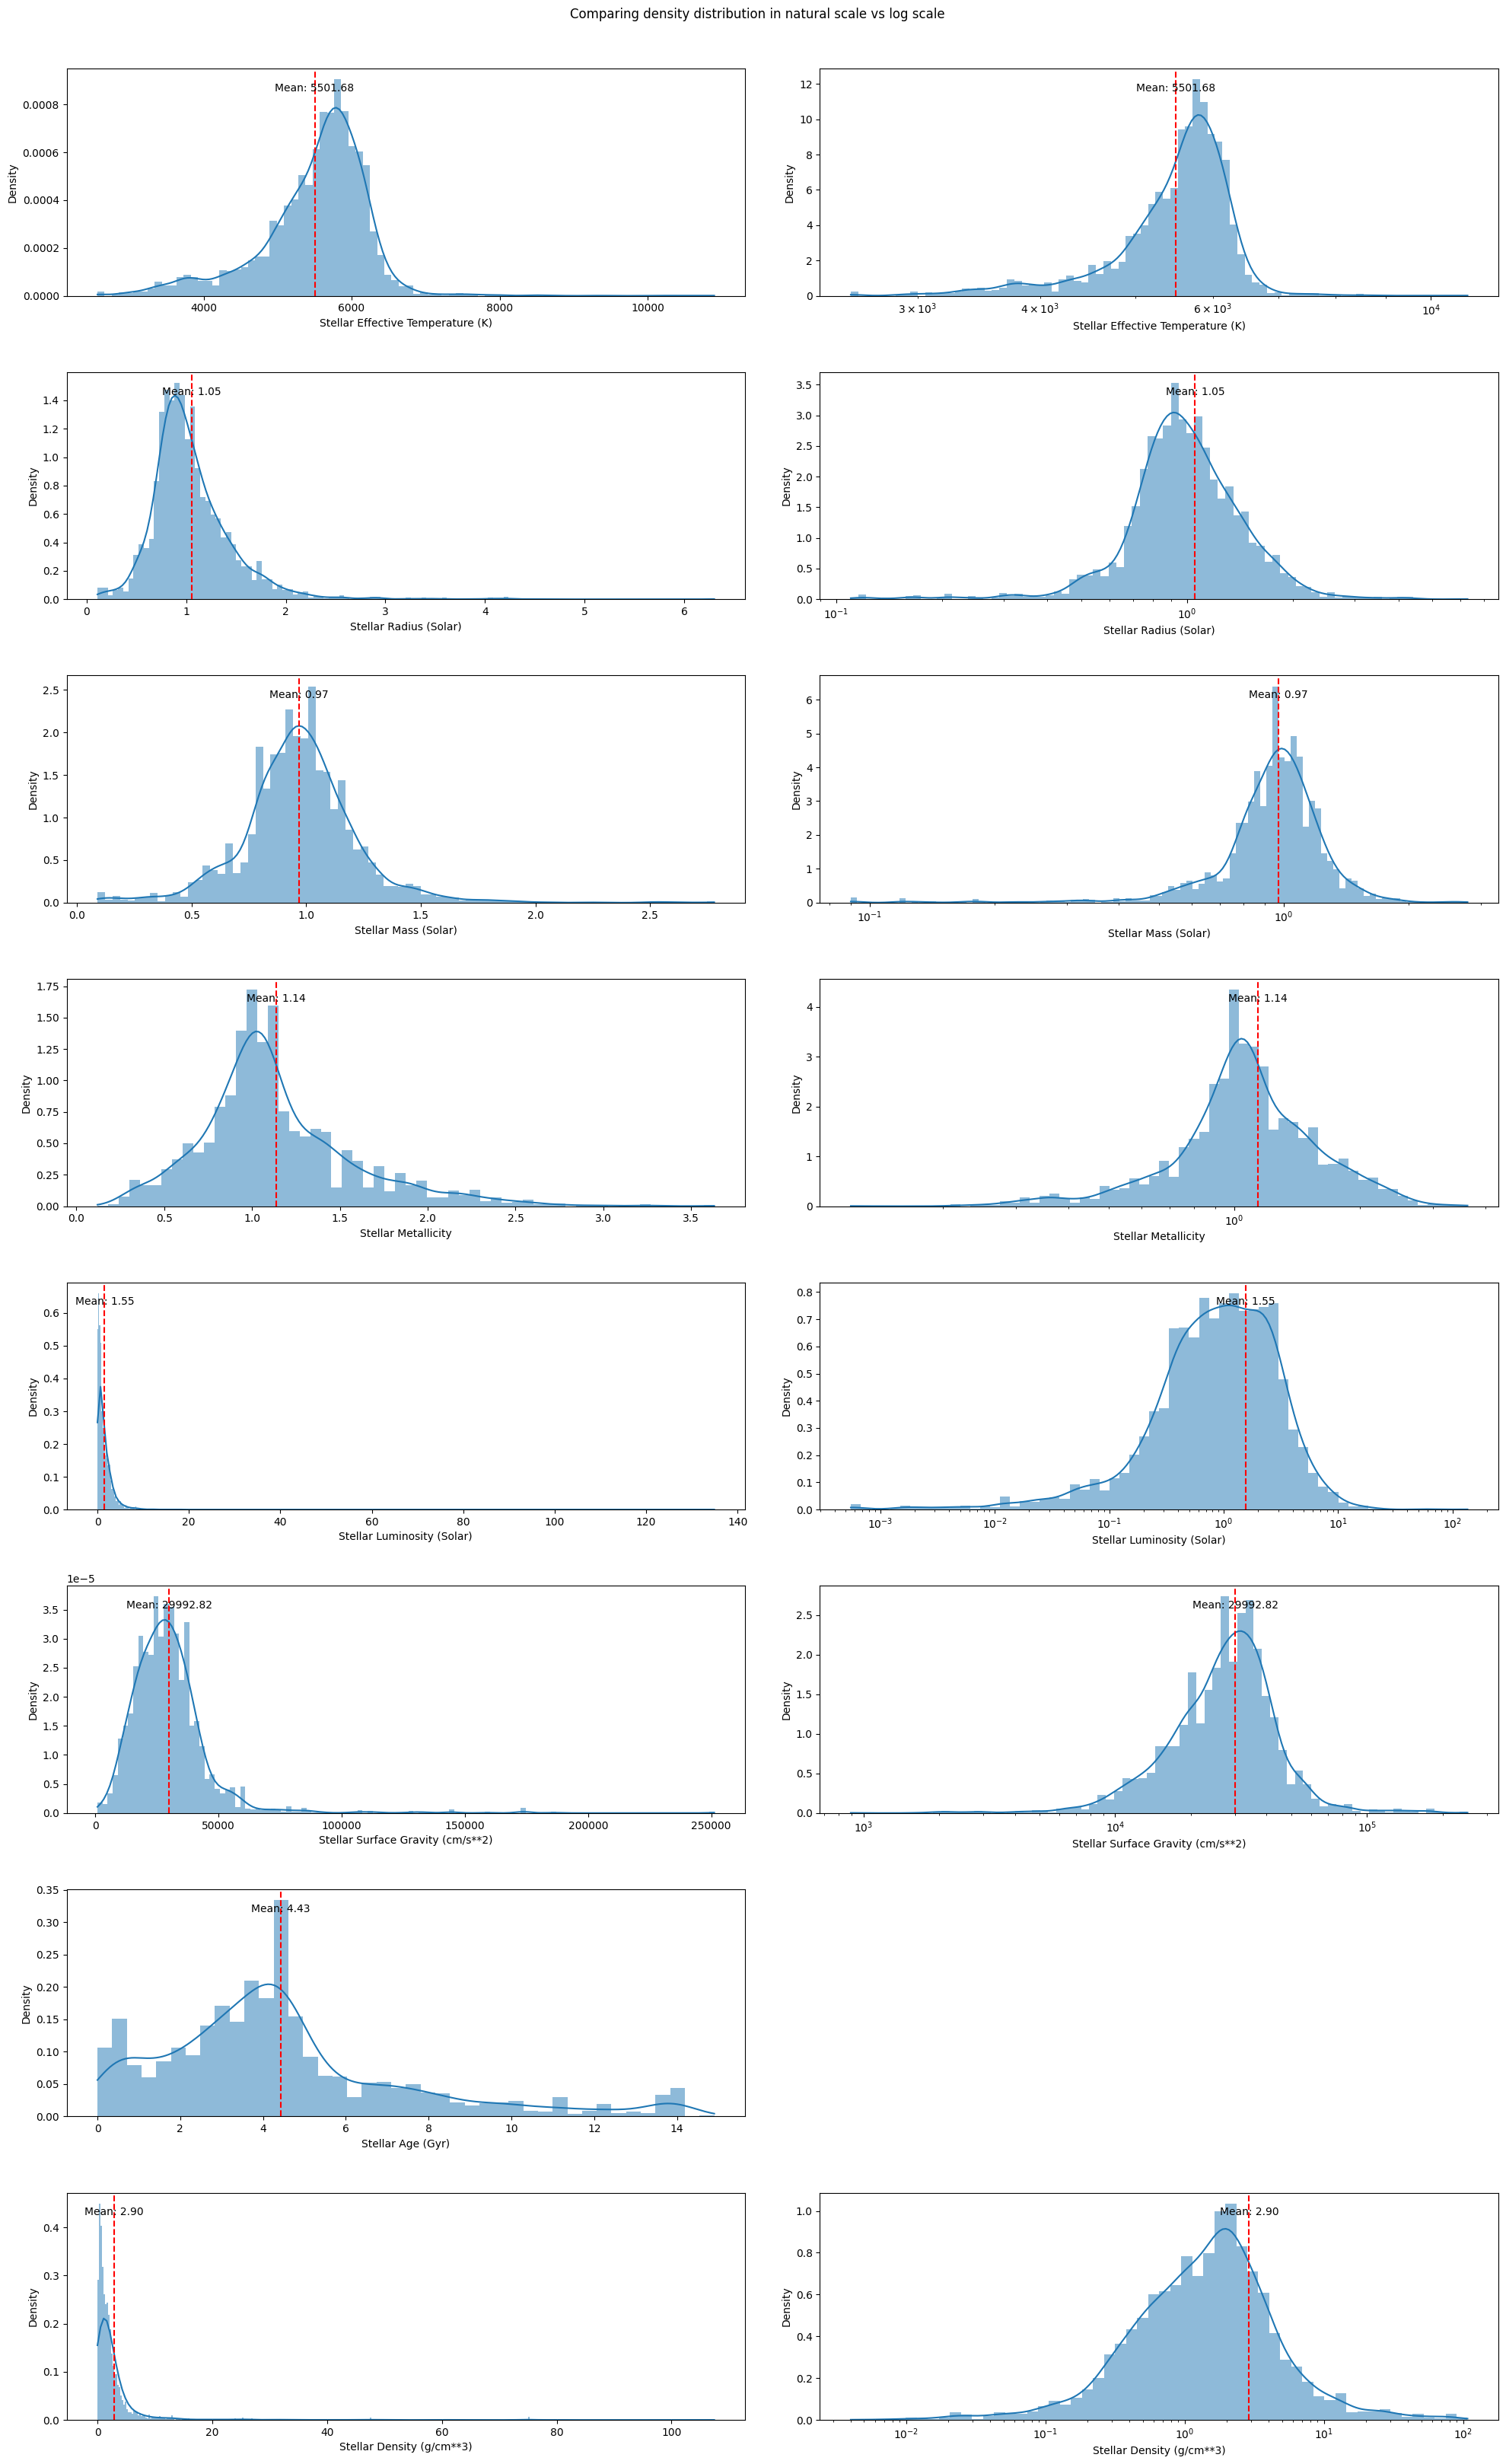

In [4]:
fig, ax = plt.subplots(8,2,figsize=(20,32))
axes = ax.flatten()

def graph_histplot(df, x, ax, xlabel, log_scale=True):
    sns.histplot(df[x], ax=ax, kde=True, stat='density', linewidth=0, log_scale=log_scale, legend=False)
    mean = np.mean(df[x])
    ax.axvline(x=mean, color='r', linestyle='--', label='Mean')
    ax.set_xlabel(xlabel)
    ax.text(mean, ax.get_ylim()[1]*0.9, f'Mean: {mean:0.2f}', ha='center')

graph_histplot(df, 'st_teff', axes[0], 'Stellar Effective Temperature (K)', log_scale=False)
graph_histplot(df, 'st_teff', axes[1], 'Stellar Effective Temperature (K)', log_scale=True)

graph_histplot(df, 'st_rad', axes[2], 'Stellar Radius (Solar)', log_scale=False)
graph_histplot(df, 'st_rad', axes[3], 'Stellar Radius (Solar)', log_scale=True)

graph_histplot(df, 'st_mass', axes[4], 'Stellar Mass (Solar)', log_scale=False)
graph_histplot(df, 'st_mass', axes[5], 'Stellar Mass (Solar)', log_scale=True)

graph_histplot(df, 'st_met_exp', axes[6], 'Stellar Metallicity', log_scale=False)
graph_histplot(df, 'st_met_exp', axes[7], 'Stellar Metallicity', log_scale=True)

graph_histplot(df, 'st_lum_exp', axes[8], 'Stellar Luminosity (Solar)', log_scale=False)
graph_histplot(df, 'st_lum_exp', axes[9], 'Stellar Luminosity (Solar)', log_scale=True)

graph_histplot(df, 'st_logg_exp', axes[10], 'Stellar Surface Gravity (cm/s**2)', log_scale=False)
graph_histplot(df, 'st_logg_exp', axes[11], 'Stellar Surface Gravity (cm/s**2)', log_scale=True)

graph_histplot(df, 'st_age', axes[12], 'Stellar Age (Gyr)', log_scale=False)
# graph_histplot('st_age', axes[13], 'Stellar Age (Gyr)', log_scale=True)

graph_histplot(df, 'st_dens', axes[14], 'Stellar Density (g/cm**3)', log_scale=False)
graph_histplot(df, 'st_dens', axes[15], 'Stellar Density (g/cm**3)', log_scale=True)


fig.suptitle('Comparing density distribution in natural scale vs log scale', y=1.01)
fig.tight_layout(h_pad=3, w_pad=3)
axes[13].axis('off')
plt.show()

In [5]:
convert = ['st_rad', 'st_teff', 'st_mass', 'st_dens'] # features to convert to log scale
drop = ['st_met_exp','st_lum_exp','st_logg_exp'] # features to drop

df[convert] = df[convert].apply(lambda x: np.log10(x), axis=1)
df = df.drop(drop, axis=1)

In [6]:
print(f"df['st_lum']   min: {df['st_lum'].min():<20} max: {df['st_lum'].max():<20} mean: {df['st_lum'].mean():<10}")
print(f"df['st_rad']   min: {df['st_rad'].min():<20} max: {df['st_rad'].max():<20} mean: {df['st_rad'].mean():<10}")
print(f"df['st_teff']  min: {df['st_teff'].min():<20} max: {df['st_teff'].max():<20} mean: {df['st_teff'].mean():<10}")
print(f"df['st_mass']  min: {df['st_mass'].min():<20} max: {df['st_mass'].max():<20} mean: {df['st_mass'].mean():<10}")
print(f"df['st_met']   min: {df['st_met'].min():<20} max: {df['st_met'].max():<20} mean: {df['st_met'].mean():<10}")
print(f"df['st_logg']  min: {df['st_logg'].min():<20} max: {df['st_logg'].max():<20} mean: {df['st_logg'].mean():<10}")
print(f"df['st_age']   min: {df['st_age'].min():<20} max: {df['st_age'].max():<20} mean: {df['st_age'].mean():<10}")
print(f"df['st_dens']  min: {df['st_dens'].min():<20} max: {df['st_dens'].max():<20} mean: {df['st_dens'].mean():<10}")

df['st_lum']   min: -3.257               max: 2.13                 mean: -0.09503686753114671
df['st_rad']   min: -0.958607314841775   max: 0.7993405494535817   mean: -0.007990827736143253
df['st_teff']  min: 3.4092566520389096   max: 4.037426497940624    mean: 3.7361692638006505
df['st_mass']  min: -1.0457574905606752  max: 0.4440447959180762   mean: -0.03147912918644023
df['st_met']   min: -0.92                max: 0.56                 mean: 0.024305873379099924
df['st_logg']  min: 2.95                 max: 5.4                  mean: 4.423391812865497
df['st_age']   min: 0.0                  max: 14.9                 mean: 4.4322890922959575
df['st_dens']  min: -2.396855627379818   max: 2.031203307608297    mean: 0.13285574367616446


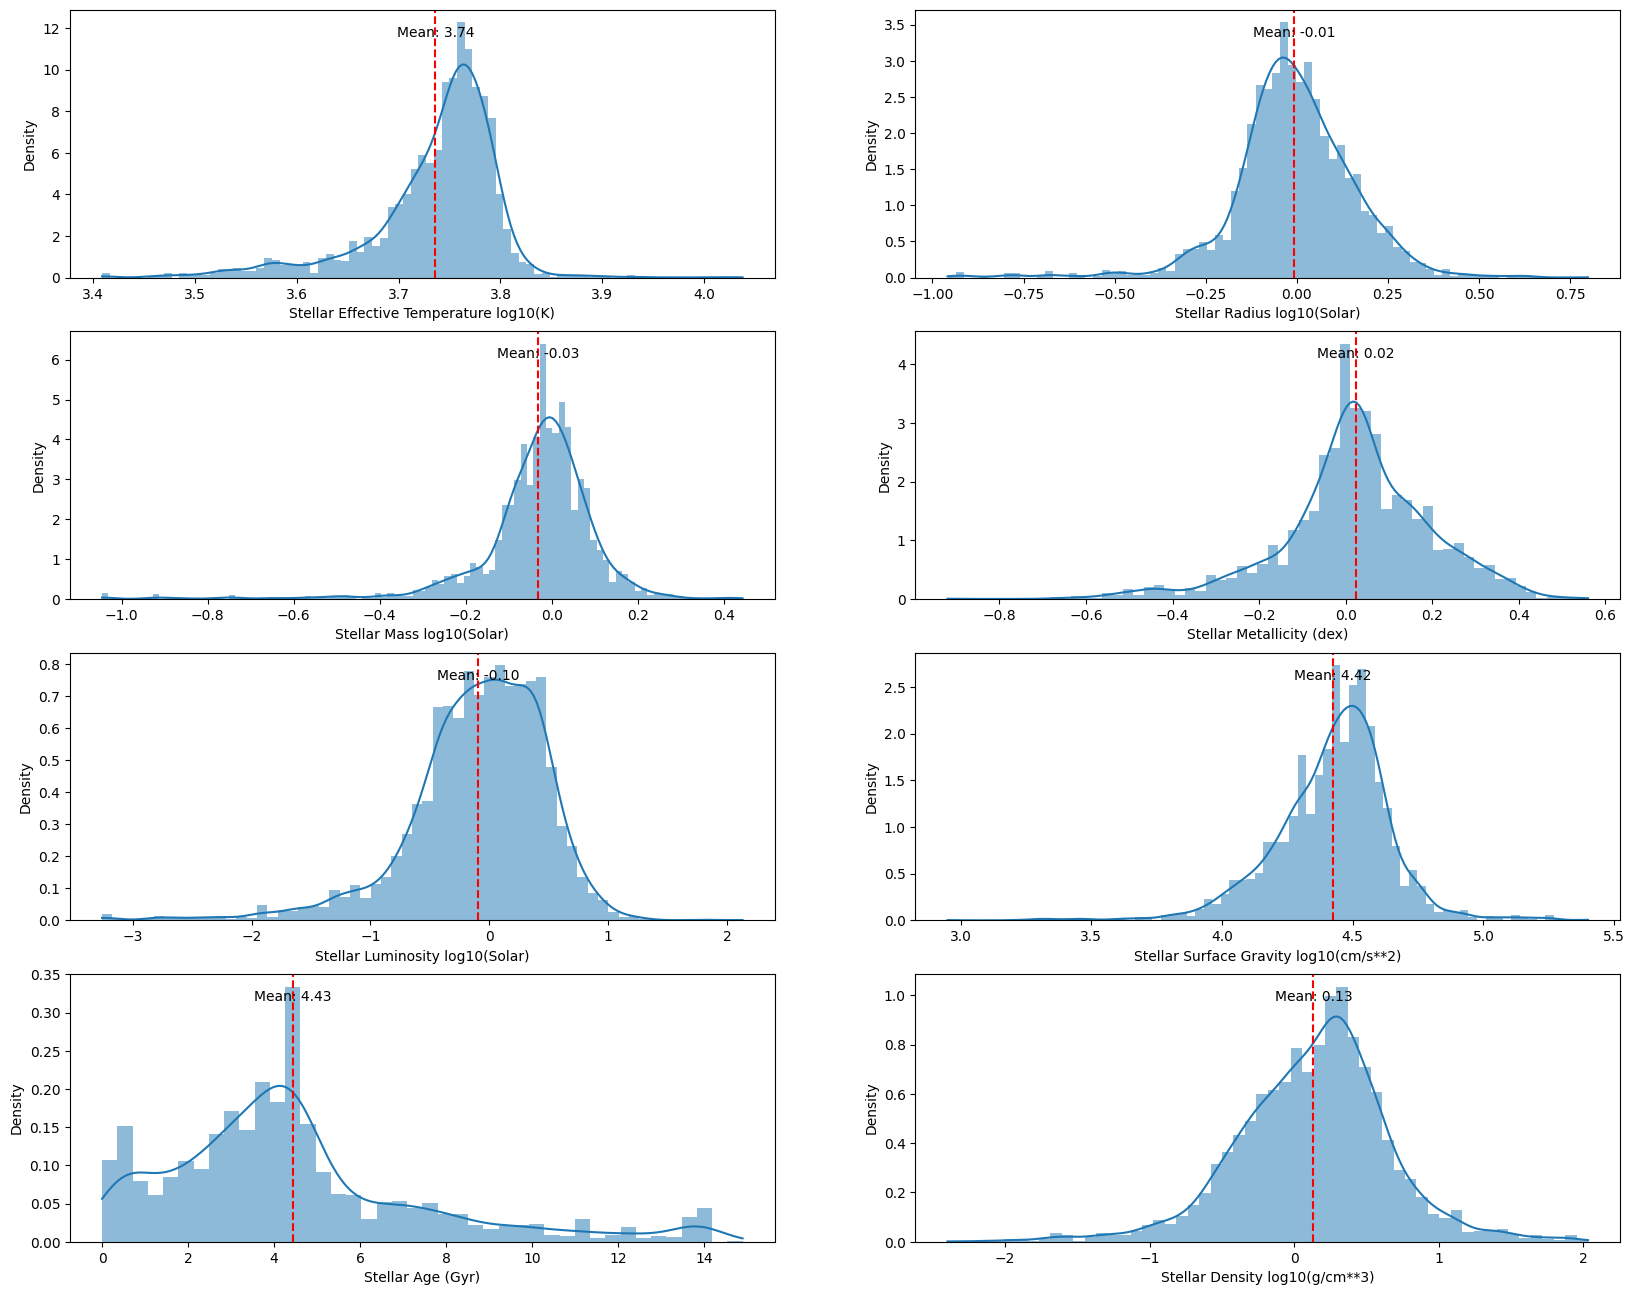

In [7]:
# Plot density graph again using the transformed data
fig, ax = plt.subplots(4,2,figsize=(20,16))
axes = ax.flatten()

graph_histplot(df, 'st_teff', axes[0], 'Stellar Effective Temperature log10(K)', log_scale=False)
graph_histplot(df, 'st_rad', axes[1], 'Stellar Radius log10(Solar)', log_scale=False)
graph_histplot(df, 'st_mass', axes[2], 'Stellar Mass log10(Solar)', log_scale=False)
graph_histplot(df, 'st_met', axes[3], 'Stellar Metallicity (dex)', log_scale=False)
graph_histplot(df, 'st_lum', axes[4], 'Stellar Luminosity log10(Solar)', log_scale=False)
graph_histplot(df, 'st_logg', axes[5], 'Stellar Surface Gravity log10(cm/s**2)', log_scale=False)
graph_histplot(df, 'st_age', axes[6], 'Stellar Age (Gyr)', log_scale=False)
graph_histplot(df, 'st_dens', axes[7], 'Stellar Density log10(g/cm**3)', log_scale=False)

plt.show()

### Standardization (z-score normalization)

Standardization rescales the data so that the dataset has a mean of $\mu = 0$ and standard deviation of $\sigma = 1$. This method works well on normally distributed data.

$${x_{new}}^{(i)} = {{(x^{(i)} - \mu)} \over \sigma}$$

### Min-max normalization

Min-max scaling rescales the data so that each of the value falls between 0 and 1.

$${x_{new}}^{(i)} = {{(x^{(i)} - x_{min})} \over {(x_{max} - x_{min})}}$$ 


Since the dataset is not normally dstributed yet, min-max scaling should be peformed first to preserve the relative scale of the feature.

In [8]:
def min_max_norm(row):
    """Scale a row of a DataFrame to a fixed range between 0 and 1 using min-max scaling."""
    return (row - row.min()) / (row.max() - row.min())

features = ['st_lum', 'st_rad', 'st_teff', 'st_mass', 'st_met', 'st_logg', 'st_age', 'st_dens']
df_norm = df[features].apply(min_max_norm, axis=1)
df_norm = pd.concat([df_norm, df.drop(features, axis=1)], axis=1)

print(f"df_norm['st_lum']   min: {df_norm['st_lum'].min():<20} max: {df_norm['st_lum'].max():<20} mean: {df_norm['st_lum'].mean():<10}")
print(f"df_norm['st_rad']   min: {df_norm['st_rad'].min():<20} max: {df_norm['st_rad'].max():<20} mean: {df_norm['st_rad'].mean():<10}")
print(f"df_norm['st_teff']  min: {df_norm['st_teff'].min():<20} max: {df_norm['st_teff'].max():<20} mean: {df_norm['st_teff'].mean():<10}")
print(f"df_norm['st_mass']  min: {df_norm['st_mass'].min():<20} max: {df_norm['st_mass'].max():<20} mean: {df_norm['st_mass'].mean():<10}")
print(f"df_norm['st_met']   min: {df_norm['st_met'].min():<20} max: {df_norm['st_met'].max():<20} mean: {df_norm['st_met'].mean():<10}")
print(f"df_norm['st_logg']  min: {df_norm['st_logg'].min():<20} max: {df_norm['st_logg'].max():<20} mean: {df_norm['st_logg'].mean():<10}")
print(f"df_norm['st_age']   min: {df_norm['st_age'].min():<20} max: {df_norm['st_age'].max():<20} mean: {df_norm['st_age'].mean():<10}")
print(f"df_norm['st_dens']  min: {df_norm['st_dens'].min():<20} max: {df_norm['st_dens'].max():<20} mean: {df_norm['st_dens'].mean():<10}")

df_norm['st_lum']   min: 0.0                  max: 0.5184290573941382   mean: 0.06008074533188623
df_norm['st_rad']   min: 0.0                  max: 0.4444015693775308   mean: 0.06871658776074593
df_norm['st_teff']  min: 0.26530833766664935  max: 1.0                  mean: 0.7605123507139535
df_norm['st_mass']  min: 0.0                  max: 0.3411621890723123   mean: 0.06479262115310447
df_norm['st_met']   min: 0.0                  max: 0.3880193009297399   mean: 0.07317648592242319
df_norm['st_logg']  min: 0.3017908159710124   max: 1.0                  mean: 0.8845900763236251
df_norm['st_age']   min: 0.0                  max: 1.0                  mean: 0.7708912003076411
df_norm['st_dens']  min: 0.0                  max: 0.6040191475319865   mean: 0.09059820292352104


In [9]:
def z_score(row):
    """Scale a row of a DataFrame to have a mean of 0 and standard deviation of 1"""
    return (row - np.mean(row)) / np.std(row)

df_std = df_norm[features].apply(z_score, axis=1)
df_std = pd.concat([df_std, df.drop(features, axis=1)], axis=1)

print(f"df_std['st_lum']   min: {df_std['st_lum'].min():<20} max: {df_std['st_lum'].max():<20} mean: {df_std['st_lum'].mean():<10}")
print(f"df_std['st_rad']   min: {df_std['st_rad'].min():<20} max: {df_std['st_rad'].max():<20} mean: {df_std['st_rad'].mean():<10}")
print(f"df_std['st_teff']  min: {df_std['st_teff'].min():<20} max: {df_std['st_teff'].max():<20} mean: {df_std['st_teff'].mean():<10}")
print(f"df_std['st_mass']  min: {df_std['st_mass'].min():<20} max: {df_std['st_mass'].max():<20} mean: {df_std['st_mass'].mean():<10}")
print(f"df_std['st_met']   min: {df_std['st_met'].min():<20} max: {df_std['st_met'].max():<20} mean: {df_std['st_met'].mean():<10}")
print(f"df_std['st_logg']  min: {df_std['st_logg'].min():<20} max: {df_std['st_logg'].max():<20} mean: {df_std['st_logg'].mean():<10}")
print(f"df_std['st_age']   min: {df_std['st_age'].min():<20} max: {df_std['st_age'].max():<20} mean: {df_std['st_age'].mean():<10}")
print(f"df_std['st_dens']  min: {df_std['st_dens'].min():<20} max: {df_std['st_dens'].max():<20} mean: {df_std['st_dens'].mean():<10}")

df_std['st_lum']   min: -1.5770674030677592  max: 0.3706031297788638   mean: -0.752254848245193
df_std['st_rad']   min: -0.9625347325002694  max: -0.29470791707564414 mean: -0.7249433340798259
df_std['st_teff']  min: 0.15141235261058394  max: 1.715396278612399    mean: 1.0725709153741905
df_std['st_mass']  min: -0.9866197466285673  max: -0.417755257920363   mean: -0.7356872993860906
df_std['st_met']   min: -1.1143417922577166  max: -0.27297331081345777 mean: -0.7122831948663705
df_std['st_logg']  min: 0.24679953328414367  max: 2.03579770829289     mean: 1.3963046419261915
df_std['st_age']   min: -0.688956894942915   max: 2.4718379462597895   mean: 1.124266542630034
df_std['st_dens']  min: -1.737355148806604   max: 0.452980586858325    mean: -0.6679734233529361


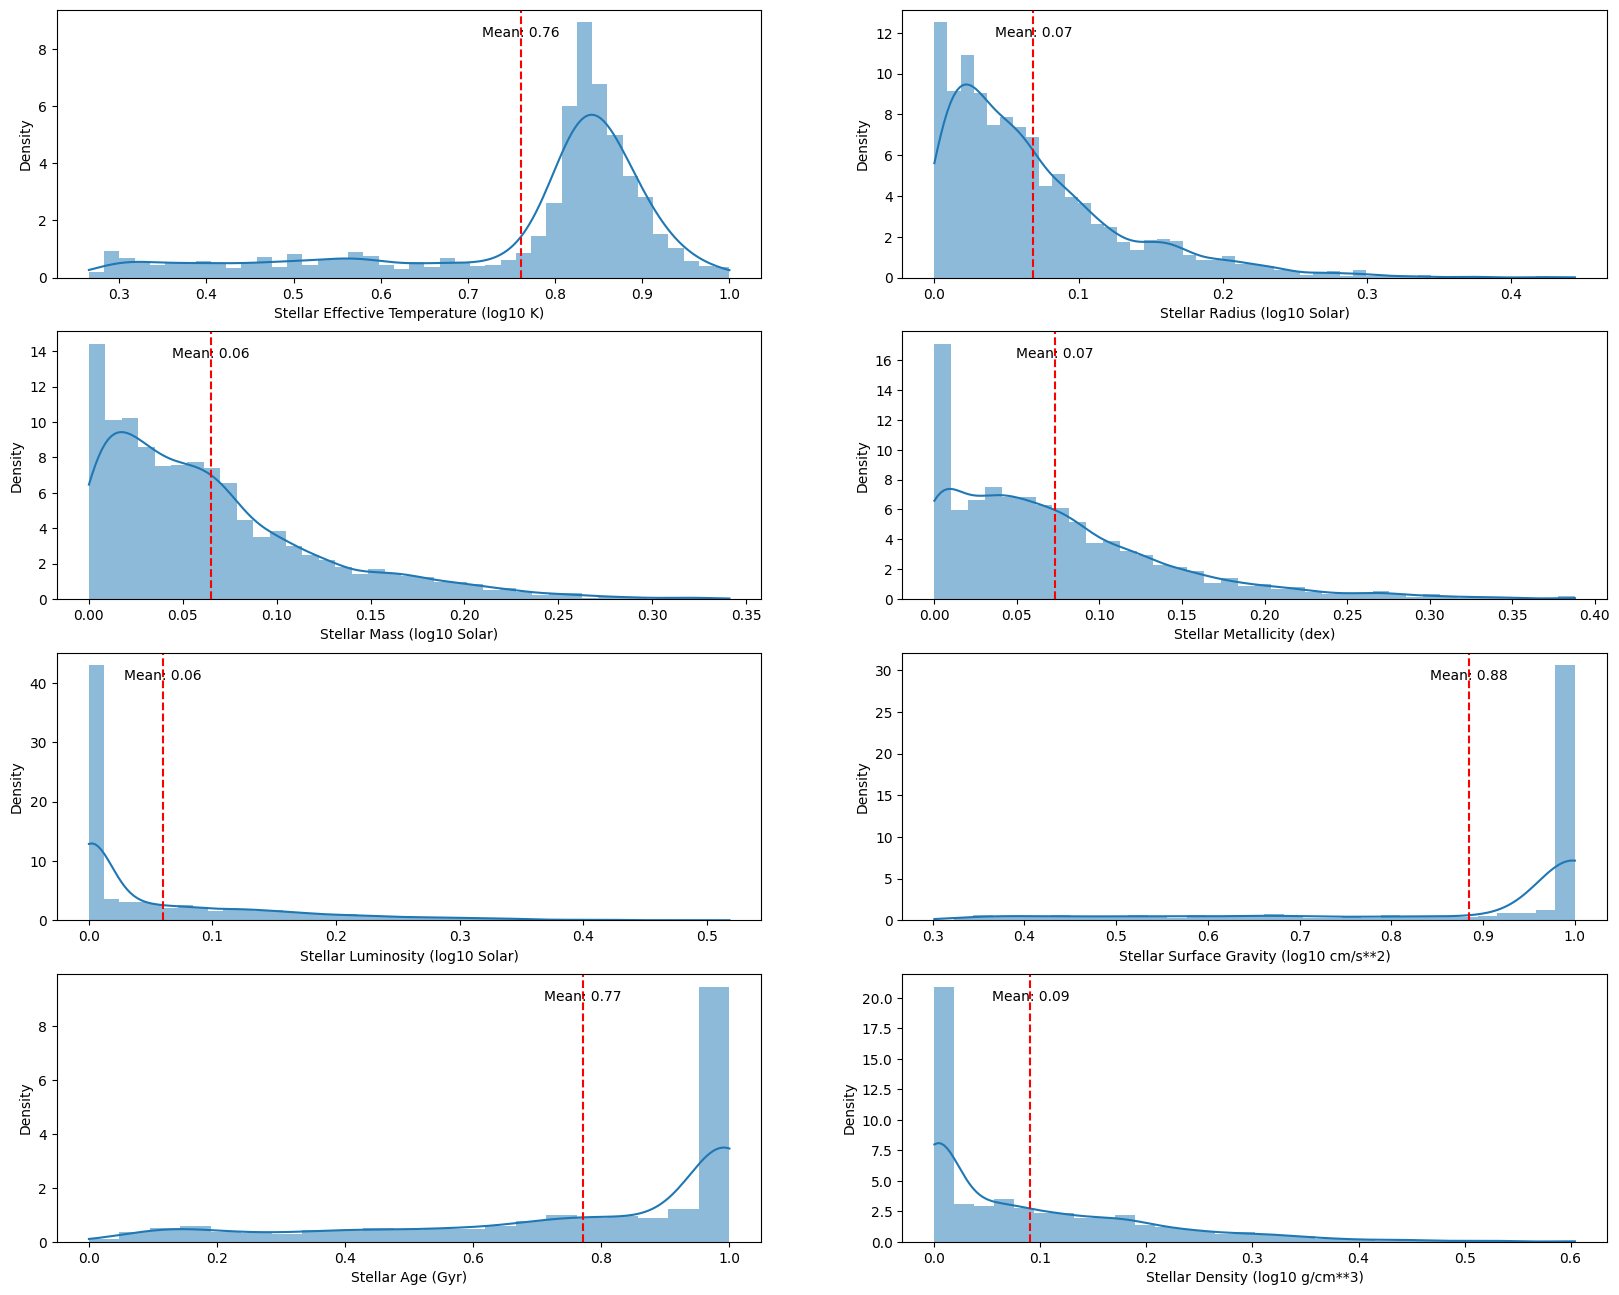

In [10]:
# Plot density graph again using the min-max scaled data
fig, ax = plt.subplots(4,2,figsize=(20,16))
axes = ax.flatten()

graph_histplot(df_norm, 'st_teff', axes[0], 'Stellar Effective Temperature (log10 K)', log_scale=False)
graph_histplot(df_norm, 'st_rad', axes[1], 'Stellar Radius (log10 Solar)', log_scale=False)
graph_histplot(df_norm, 'st_mass', axes[2], 'Stellar Mass (log10 Solar)', log_scale=False)
graph_histplot(df_norm, 'st_met', axes[3], 'Stellar Metallicity (dex)', log_scale=False)
graph_histplot(df_norm, 'st_lum', axes[4], 'Stellar Luminosity (log10 Solar)', log_scale=False)
graph_histplot(df_norm, 'st_logg', axes[5], 'Stellar Surface Gravity (log10 cm/s**2)', log_scale=False)
graph_histplot(df_norm, 'st_age', axes[6], 'Stellar Age (Gyr)', log_scale=False)
graph_histplot(df_norm, 'st_dens', axes[7], 'Stellar Density (log10 g/cm**3)', log_scale=False)

plt.show()

## Linear regression assumptions

1. Linear relationship
- there must exist a linear relationship between each independent variables and the dependent variable
2. Homoscedasticity
- the residuals have constant variance at every level of x
3. Normality
- the residuals of the model are normally distributed

### Linear relationship test

You can visually determine if there is a linear relationship between the variable x and y by creating a scatter plot. If the points roughly fall under a straigt line, it indicates that there is a linear relationship.

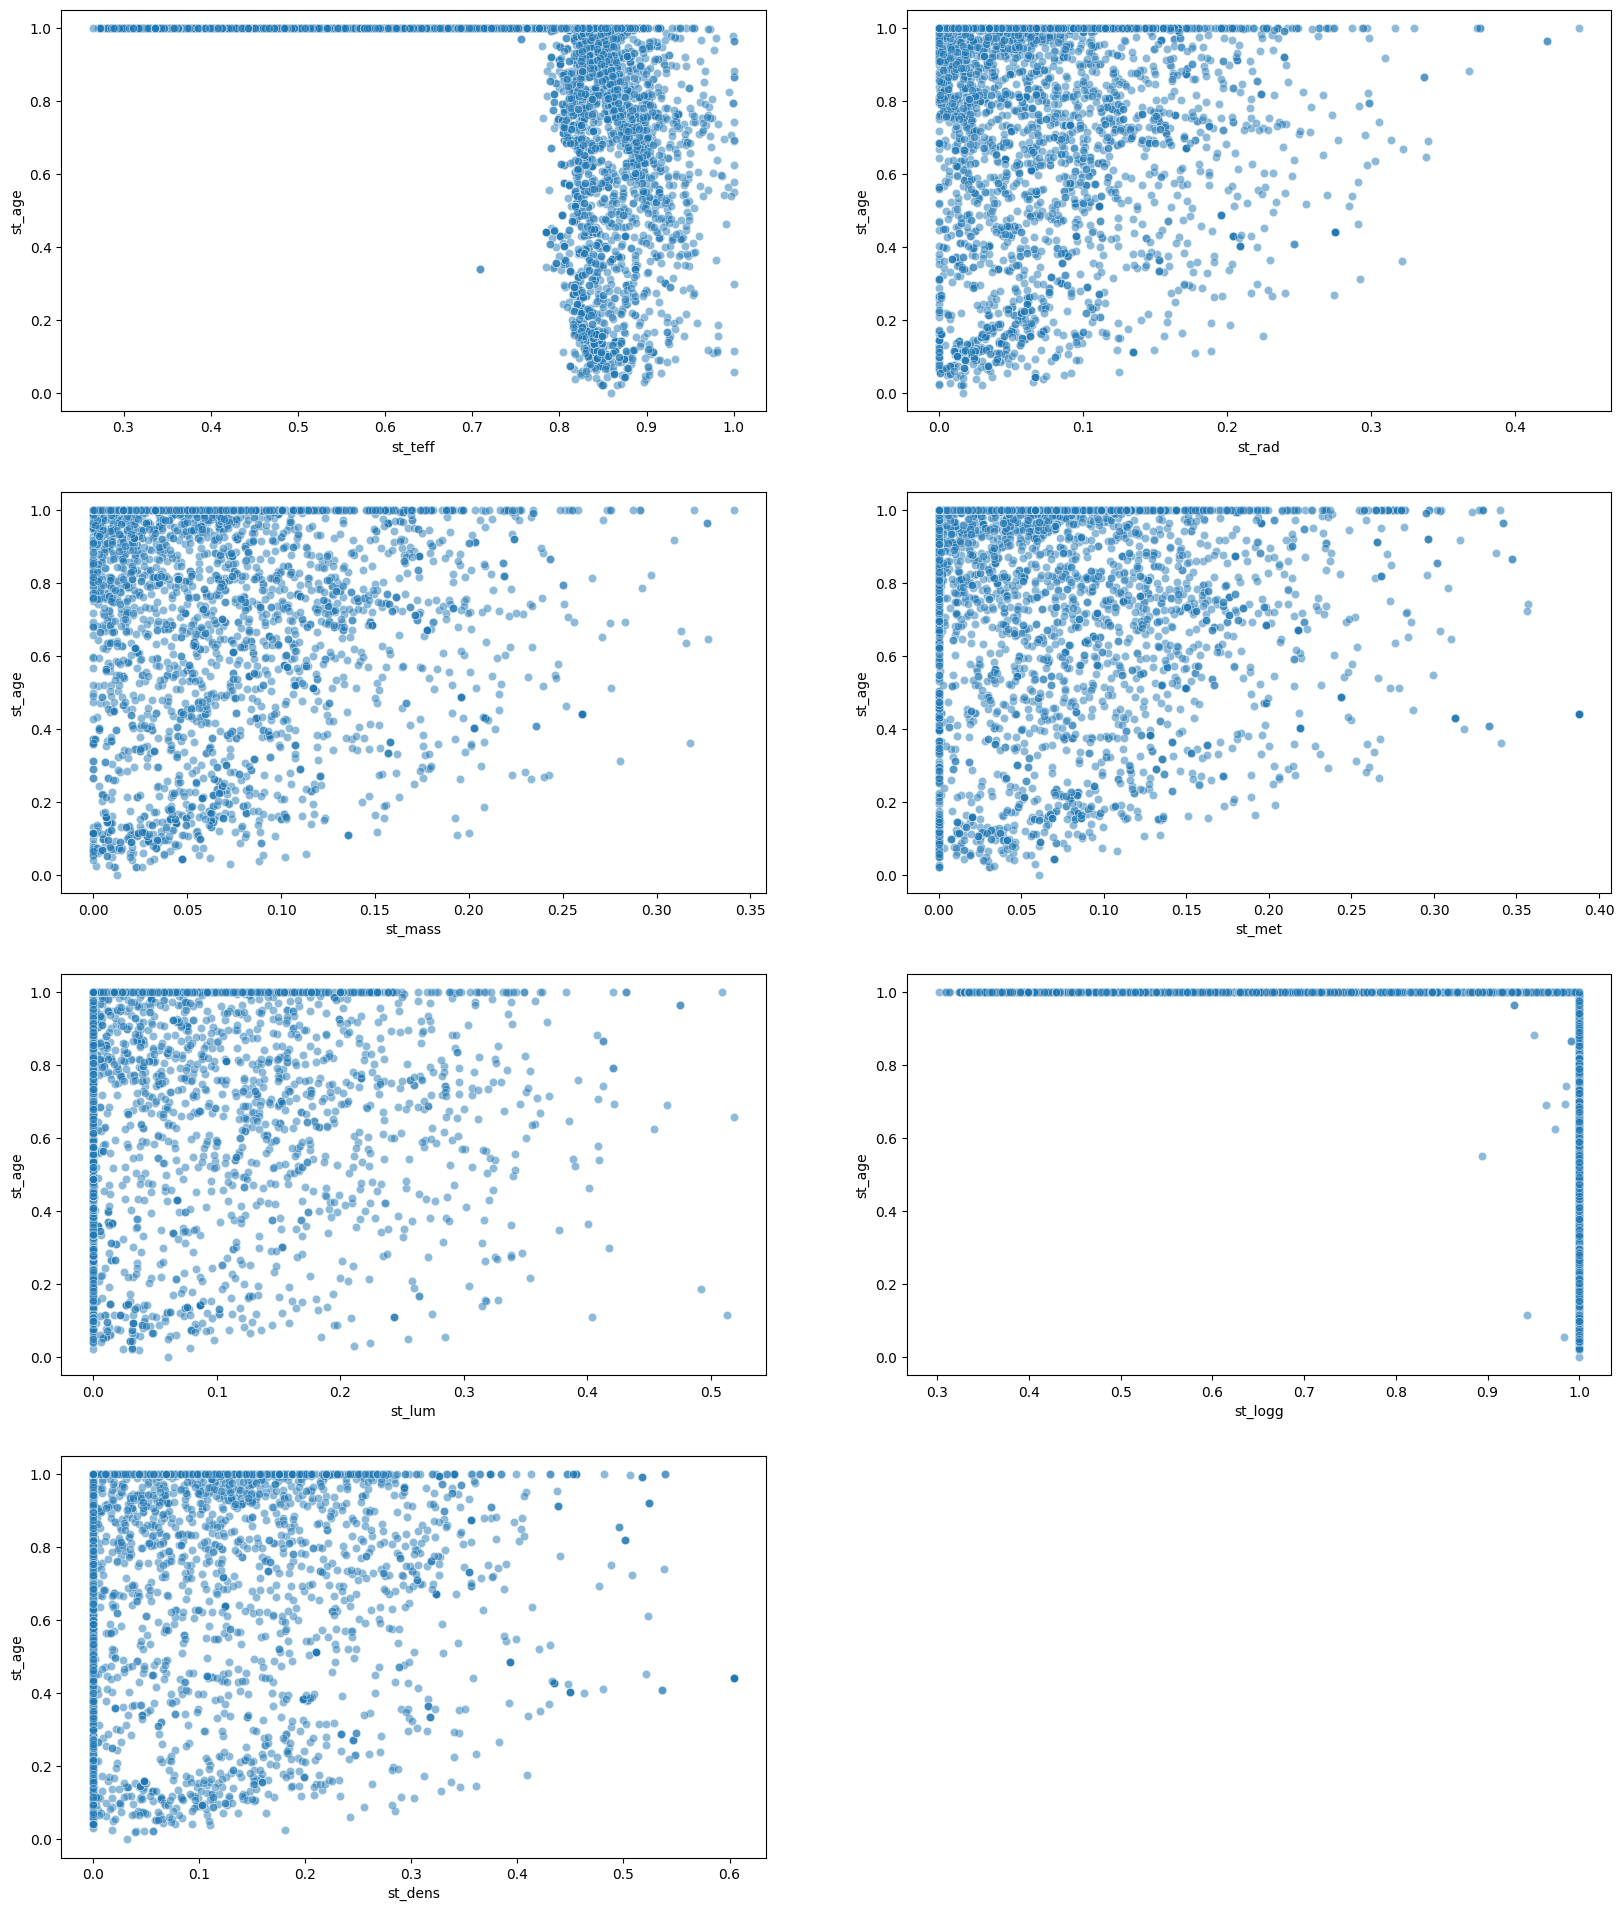

In [11]:
fig, ax = plt.subplots(4,2,figsize=(20,24))
axes = ax.flatten()

def graph_scatterplot(df, x, y, ax, title, xlabel, ylabel):
    sns.scatterplot(x=x, y=y, data=df, ax=ax, alpha=0.5)

graph_scatterplot(df_norm, 'st_teff', 'st_age', axes[0], 'Temperature vs Age', 'Temperature log10(K)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_rad', 'st_age', axes[1], 'Radius vs Age', 'Radius log10(Solar)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_mass', 'st_age', axes[2], 'Mass vs Age', 'Mass log10(Solar)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_met', 'st_age', axes[3], 'Metalicity vs Age', 'Metalicity (dex)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_lum', 'st_age', axes[4], 'Luminosity vs Age', 'Luminosity log10(Solar)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_logg', 'st_age', axes[5], 'Surface Gravity vs Age', 'Gravity log10(cm/s**2)', 'Age (Gyr)')
graph_scatterplot(df_norm, 'st_dens', 'st_age', axes[6], 'Density vs Age', 'Density log10(g/cm**3)', 'Age (Gyr)')
axes[7].axis('off')
plt.show()

## Split dataset into Train and Test

Among the planets that have the temperature data, split the dataset into two groups: train(70%) and test(30%).

In [12]:
from sklearn.model_selection import train_test_split

y = df_norm['st_age']
X = df_norm.drop(['st_age','hostname'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # random state is used to get the same output each time

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# change shape from (m,) to (m, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2753, 7)
y_train shape: (2753, 1)
X_test shape: (1180, 7)
y_test shape: (1180, 1)


## Compute cost

The model function for linear regression which is a function that maps from `X` (star parameters) to `y` (star age (Gyr)) is represented as: $$f_{W,b}(X) = WX + b$$
To train this linear regression model, you need to find the best $(W,b)$ parameters that fit your dataset.
To compare how a one parameter $(W,b)$ is better or worse than another is by evaluating it with a cost function $J(W,b)$.


The cost function is defined as: $$J(W,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) - y^{(i)})^2$$

where $m$ is the number of training examples, $f_{W,b}(X^{(i)})$ is the model's prediction of the star's age and $y^{(i)}$ is the actual star's age from the dataset.

In [13]:
def compute_cost(X, y, W, b): 
    """
    Computes the cost function for multi-variable linear regression.
    
    Arguments:
    X: input matrix of shape (m, n)
    y: output vector of shape (m, 1)
    W: weight vector of shape (1, n)
    b: bias scalar
    
    Returns
    cost: scalar value of the cost function
    """
    
    m = X.shape[0] # number of training examples
    f_Wb = np.dot(X, W.T) + b  # predicted output values
    loss = (f_Wb - y)**2  # squared error 
    cost = np.sum(loss) / (2 * m)  # compute cost using mean squared error
    
    return cost

## Gradient descent

The parameter that fits the data best will have the smallest cost $J(W,b)$. Gradient descent is used to find that smallest cost by stepping closer to the optimal value. 
The algorithm for gradient descent is:
$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline\; 
& \phantom {0000} b := b -  \alpha \frac{\partial J(W,b)}{\partial b} \newline\; 
& \phantom {0000} W := W -  \alpha \frac{\partial J(W,b)}{\partial W} \; \newline 
& \rbrace\end{align*}$$

where parameters $W$, $b$ are both updated simultaniously and where:
$$\frac{\partial J(W,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) - y^{(i)})$$

$$\frac{\partial J(W,b)}{\partial W}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) -y^{(i)})X^{(i)}$$

In [14]:
def compute_gradient(X, y, W, b): 
    """
    Compute the gradient of the cost function for multi-variable linear regression.

    Arguments:
    X: input matrix of shape (m, n)
    y: output vector of shape (m, 1)
    b: bias scalar
    
    Returns
    dj_dW: The gradient of the cost with respect to the parameters W
    dj_db: The gradient of the cost with respect to the parameter b     
    """

    m = X.shape[0]  # number of training examples
    f_Wb = np.dot(X, W.T) + b  # predicted output values
    diff = f_Wb - y  # difference between predicted and true output values
    
    dj_dW = np.dot(diff.T, X) / m  # gradient with respect to the weights
    dj_db = np.sum(diff) / m  # gradient with respect to the bias

    return dj_dW, dj_db

## Batch gradient descent

In [15]:
def gradient_descent(X, y, W_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent

    Arguments:
    X: input matrix of shape (m, n)
    y: output vector of shape (m, 1)
    W_in: initial weight vector of shape (1, n)
    b_in: initial bias scalar
    cost_function: function to compute the cost given X, y, W, and b
    gradient_function: function to compute the gradient of the cost function given X, y, W, and b
    alpha: learning rate
    num_iters: number of iterations to run gradient descent

    Returns:
    W: optimal weight vector of shape (1, n)
    b: optimal bias scalar
    """

    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    W_history = []
    W = copy.deepcopy(W_in)  # Avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_dW, dj_db = gradient_function(X, y, W, b)  

        # Update Parameters using w, b, alpha and gradient
        W = W - alpha * dj_dW               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i < 100000:      # prevent resource exhaustion 
            cost = cost_function(X, y, W, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            W_history.append(W)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}")
        
    return W, b, J_history, W_history # Return W and J,W history for graphing

In [16]:
m,n = X_train.shape # m is the number of samples and n is the number of features

initial_W = np.random.randn(1, n) * 0.01
initial_b = 0.0

# gradient descent settings
iterations = 5000000
alpha = 0.005

W,b,J_history,W_history = gradient_descent(X_train, y_train, initial_W, initial_b, compute_cost, compute_gradient, alpha, iterations)
print("W,b found by gradient descent:", W, b)

Iteration    0: Cost     0.33
Iteration 500000: Cost     0.03
Iteration 1000000: Cost     0.03
Iteration 1500000: Cost     0.03
Iteration 2000000: Cost     0.03
Iteration 2500000: Cost     0.03
Iteration 3000000: Cost     0.03
Iteration 3500000: Cost     0.03
Iteration 4000000: Cost     0.03
Iteration 4500000: Cost     0.03
W,b found by gradient descent: [[-0.28948554  2.85236846 -0.90831935 -2.38342635  0.06780518  0.11420258
  -0.22385803]] 1.3513298604325452


In [17]:
def predict(X, W, b):
    """
    Predicts the target variable given the input features and learned parameters.

    Parameters:
    X: input matrix of shape (m, n)
    W: weight vector of shape (n, 1)
    b: bias scalar

    Returns:
    y_pred: predicted targe variable of shape shape (m, 1).
    """
    y_pred = np.dot(X, W.T) + b

    return y_pred

In [18]:
# Compute accuracy on our training set
p_train = predict(X_train, W,b) 
diff = np.abs(p_train - y_train)
accuracy = np.mean(diff < 0.5)
print(f"Train Accuracy: {accuracy * 100} %")

# Compute accuracy on our test set
p_test = predict(X_test, W,b) 
diff = np.abs(p_test - y_test)
accuracy = np.mean(diff < 0.5)
print(f"Test Accuracy: {accuracy * 100} %")

Train Accuracy: 93.28005811841628 %
Test Accuracy: 93.38983050847457 %


## Regularization


The cost function for regularized linear regression is defined as: $$J(W,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m} \sum\limits_{j=0}^{n-1}W_{j}^2$$

The regularization term $\frac{\lambda}{2m} \sum\limits_{j=0}^{n-1}W_{j}^2$ is added to prevent overfitting. The addition of $L_{2}$ norm of the $W$ to the loss expression can make the linear function prefer solution with smaller norms. 


The regularization term is also added to the gradient calculation:

$$\frac{\partial J(W,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) - y^{(i)})$$

$$\frac{\partial J(W,b)}{\partial W}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{W,b}(X^{(i)}) -y^{(i)})X^{(i)} + \frac{\lambda}{2m}W$$

In [19]:
def compute_cost_reg(X, y, W, b, lambda_ = 1): 
    """
    Computes the cost function for multi-variable linear regression with regularization
    
    Arguments:
    X: input matrix of shape (m, n)
    y: output vector of shape (m, 1)
    W: weight vector of shape (1, n)
    b: bias scalar
    lambda_ : regulariaziton parameter
    
    Returns
    cost: scalar value of the cost function
    """
    
    m = X.shape[0] # number of training examples
    n = X.shape[1] # number of features
    f_Wb = np.dot(X, W.T) + b  # predicted output values
    loss = (f_Wb - y)**2  # squared error 
    cost = np.sum(loss) / (2 * m)  # compute cost using mean squared error
    
    # regularization
    reg_cost = (lambda_ * np.sum(np.dot(W, W.T))) / (2 * m)
    
    return cost + reg_cost

In [20]:
def compute_gradient_reg(X, y, W, b, lambda_ = 1): 
    """
    Compute the gradient of the cost function for multi-variable linear regression with regularization

    Arguments:
    X: input matrix of shape (m, n)
    y: output vector of shape (m, 1)
    b: bias scalar
    lambda_ : regulariaziton parameter
    
    Returns
    dj_dW: The gradient of the cost with respect to the parameters W
    dj_db: The gradient of the cost with respect to the parameter b     
    """

    m = X.shape[0]  # number of training examples
    f_Wb = np.dot(X, W.T) + b  # predicted output values
    diff = f_Wb - y  # difference between predicted and true output values
    
    dj_dW = np.dot(diff.T, X) / m  + (lambda_/m)*W # gradient with respect to the weights
    dj_db = np.sum(diff) / m  # gradient with respect to the bias

    return dj_dW, dj_db

In [21]:
# m,n = X_train.shape # m is the number of samples and n is the number of features

# initial_W = np.random.randn(1, n) * 0.01
# initial_b = 0.0

# gradient descent settings
# iterations = 5000000
# alpha = 0.005

W_reg,b_reg,J_history_reg,W_history_reg = gradient_descent(X_train, y_train, initial_W, initial_b, compute_cost_reg, compute_gradient_reg, alpha, iterations)
print("W,b found by gradient descent:", W_reg, b_reg)

Iteration    0: Cost     0.33
Iteration 500000: Cost     0.03
Iteration 1000000: Cost     0.03
Iteration 1500000: Cost     0.03
Iteration 2000000: Cost     0.03
Iteration 2500000: Cost     0.03
Iteration 3000000: Cost     0.03
Iteration 3500000: Cost     0.03
Iteration 4000000: Cost     0.03
Iteration 4500000: Cost     0.03
W,b found by gradient descent: [[-0.18409784  0.54538805 -0.34511172 -0.26938899  0.19202162 -0.38847518
  -0.13635809]] 1.3657369145139182


In [24]:
# Compute accuracy on our training set
p_train_reg = predict(X_train, W_reg,b_reg) 
diff = np.abs(p_train_reg - y_train)
accuracy = np.mean(diff < 0.5)
print(f"Train Accuracy: {accuracy * 100} %")

# Compute accuracy on our test set
p_test_reg = predict(X_test, W_reg,b_reg) 
diff = np.abs(p_test_reg - y_test)
accuracy = np.mean(diff < 0.5)
print(f"Test Accuracy: {accuracy * 100} %")

Train Accuracy: 92.62622593534327 %
Test Accuracy: 92.96610169491527 %
